# Import Libraries

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
import seaborn as sns


In [8]:
data = pd.read_csv(r'C:\Users\tom3r\OneDrive\Desktop\GCCR/gccr003_data.csv',sep=';',encoding= 'unicode_escape')


# Pre-Processing

In [ ]:
data["Date_of_onset"] = pd.to_datetime(data["Date_of_onset"], dayfirst=True)
data["Email_Time_Stamp_y"] = pd.to_datetime(data["Email_Time_Stamp_y"], dayfirst=True)

data = data.dropna(subset=['Date_of_onset', 'Email_Time_Stamp_y'])
data['DurationInDays'] = ((data['Email_Time_Stamp_y'] - data['Date_of_onset']).dt.total_seconds() / (60 * 60 * 24))

data = data[data['Date_of_onset'].dt.year > 2018] # Include data after COVID

data.info()
data.describe()
data.head()


In [ ]:
def islonghauler(row):
    percent_smell_recovery = row['percentage_recovery_smell']
    percent_taste_recovery = row['percentage_recovery_taste']
    long_hauler = 0
    
    if (percent_smell_recovery <= 80)  or (percent_taste_recovery<= 80):
        long_hauler =1
    else:
        long_hauler =0
    return long_hauler

data['longhauler']=data.apply(islonghauler,axis=1)

In [ ]:
covid_positive = new_df.copy()
covid_positive = covid_positive.query('COVID_diagnosis_y == 2')


In [121]:

# Separate classifications of “return to normal” will be created for taste and for smell.
# We will a) perform survival analysis for chemosensory long haulers, using time in days between the date of onset of initial symptoms and the completion day of the follow-up survey.
# We will also b) use linear regression to predict the difference score using the degree of loss in an initial survey and in a follow-up survey, controlling for time passed between the two surveys.

# data = pd.read_csv(r'C:/Users/bicers/gccr003_data.csv',sep=';',encoding='unicode_escape')
# data = pd.read_csv(r'C:\Users\tom3r\OneDrive\Desktop\GCCR/gccr003_data.csv',sep=';',encoding= 'unicode_escape')





In [101]:
# create new dataframe variables
smell_df = covid_positive[['DurationInDays', 'Smell_before_illness', 'Smell_current', 'longhauler']]
taste_df = covid_positive[['DurationInDays', 'Taste_before_illness', 'Taste_current', 'longhauler']]


In [102]:
# drop nan records
smell_df = smell_df.dropna()
taste_df = taste_df.dropna()


In [103]:
# Individuals who reported severe chemosensory dysfunction pre-COVID (i.e., before illness rating <50 for “before illness rating” on the original survey) will be excluded.
smell_df = smell_df[smell_df['Smell_before_illness'] >= 50]
taste_df = taste_df[taste_df['Taste_before_illness'] >= 50]


In [104]:
# calculate recovery percentages
smell_df['percentage_recovery'] = smell_df['Smell_current'] / smell_df['Smell_before_illness'] * 100
taste_df['percentage_recovery'] = taste_df['Taste_current'] / taste_df['Taste_before_illness'] * 100


In [105]:
smell_df.head()

,DurationInDays,Smell_before_illness,Smell_current,longhauler,percentage_recovery
0,194.604861,89.5,31.0,1,34.636872
4,233.609028,98.5,100.0,0,101.522843
6,178.611806,97.9,70.2,1,71.705822
10,156.614583,99.1,85.4,0,86.175580
19,124.632639,100.0,8.8,1,8.800000


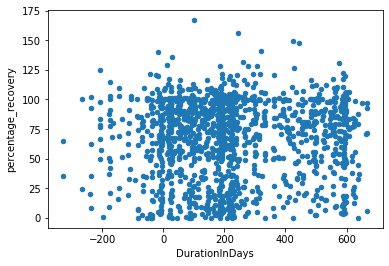

In [106]:
ax1 = smell_df.plot.scatter(x='DurationInDays',
                      y='percentage_recovery')

In [107]:
# Individuals who do not have a follow upt rating that is at least 80% of their pre-illness function rating will be classified as chemosensory long-haulers.
# Status is 0 for normal, 1 for long-haulers
# smell_df.loc[smell_df['percentage_recovery'] >= 80, 'Status'] = 0
# smell_df.loc[smell_df['percentage_recovery'] < 80, 'Status'] = 1
# taste_df.loc[taste_df['percentage_recovery'] >= 80, 'Status'] = 0
# taste_df.loc[taste_df['percentage_recovery'] < 80, 'Status'] = 1


In [108]:

smell_df["Status"] = smell_df["Status"].astype('bool')
taste_df["Status"] = taste_df["Status"].astype('bool')


In [110]:
# study for smell
smell_X = smell_df[['DurationInDays']]
smell_y = smell_df['Smell_current'] - smell_df['Smell_before_illness']


In [111]:
X_train, X_test, y_train, y_test = train_test_split(smell_X, smell_y, test_size=0.2)
lm = LinearRegression()
lm.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Coefficients: 
 [0.00201935]


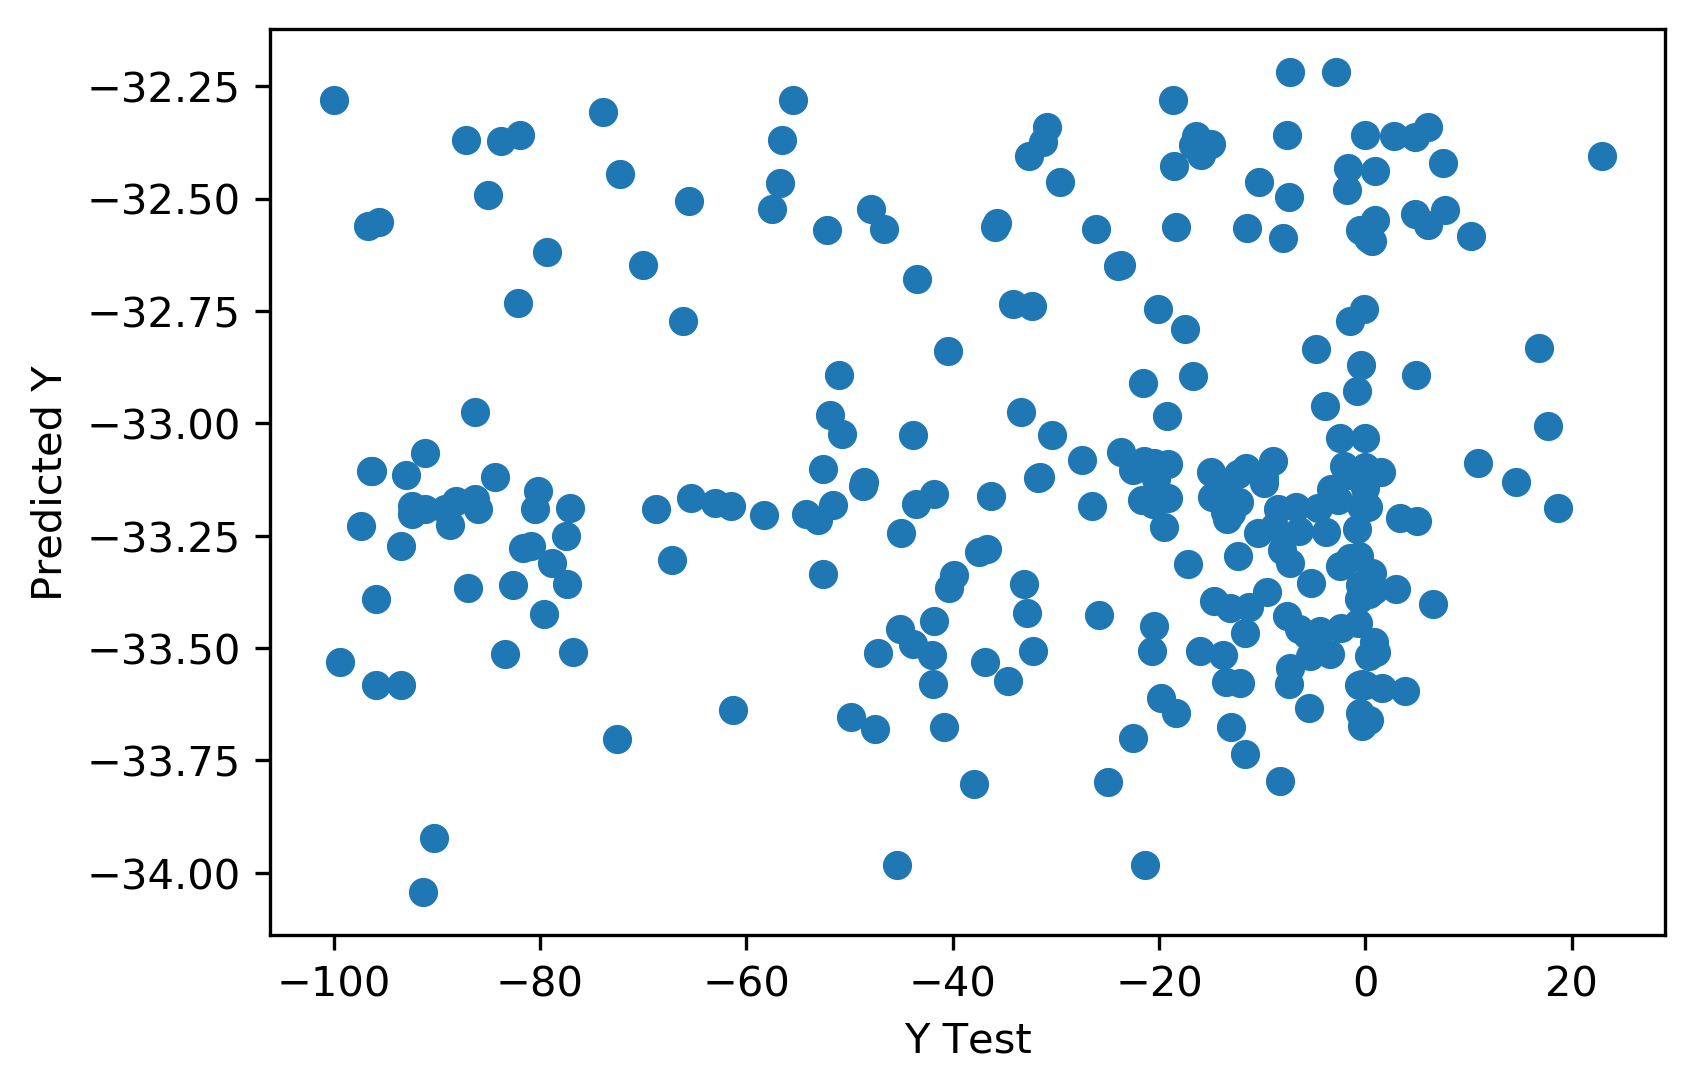

In [112]:
print('Coefficients: \n', lm.coef_)
predictions = lm.predict(X_test)
plt.figure(dpi=300)
plt.scatter(y_test, predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()


In [113]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))


MAE: 27.6972481975298
MSE: 1030.085388878276
RMSE: 32.09494335371658


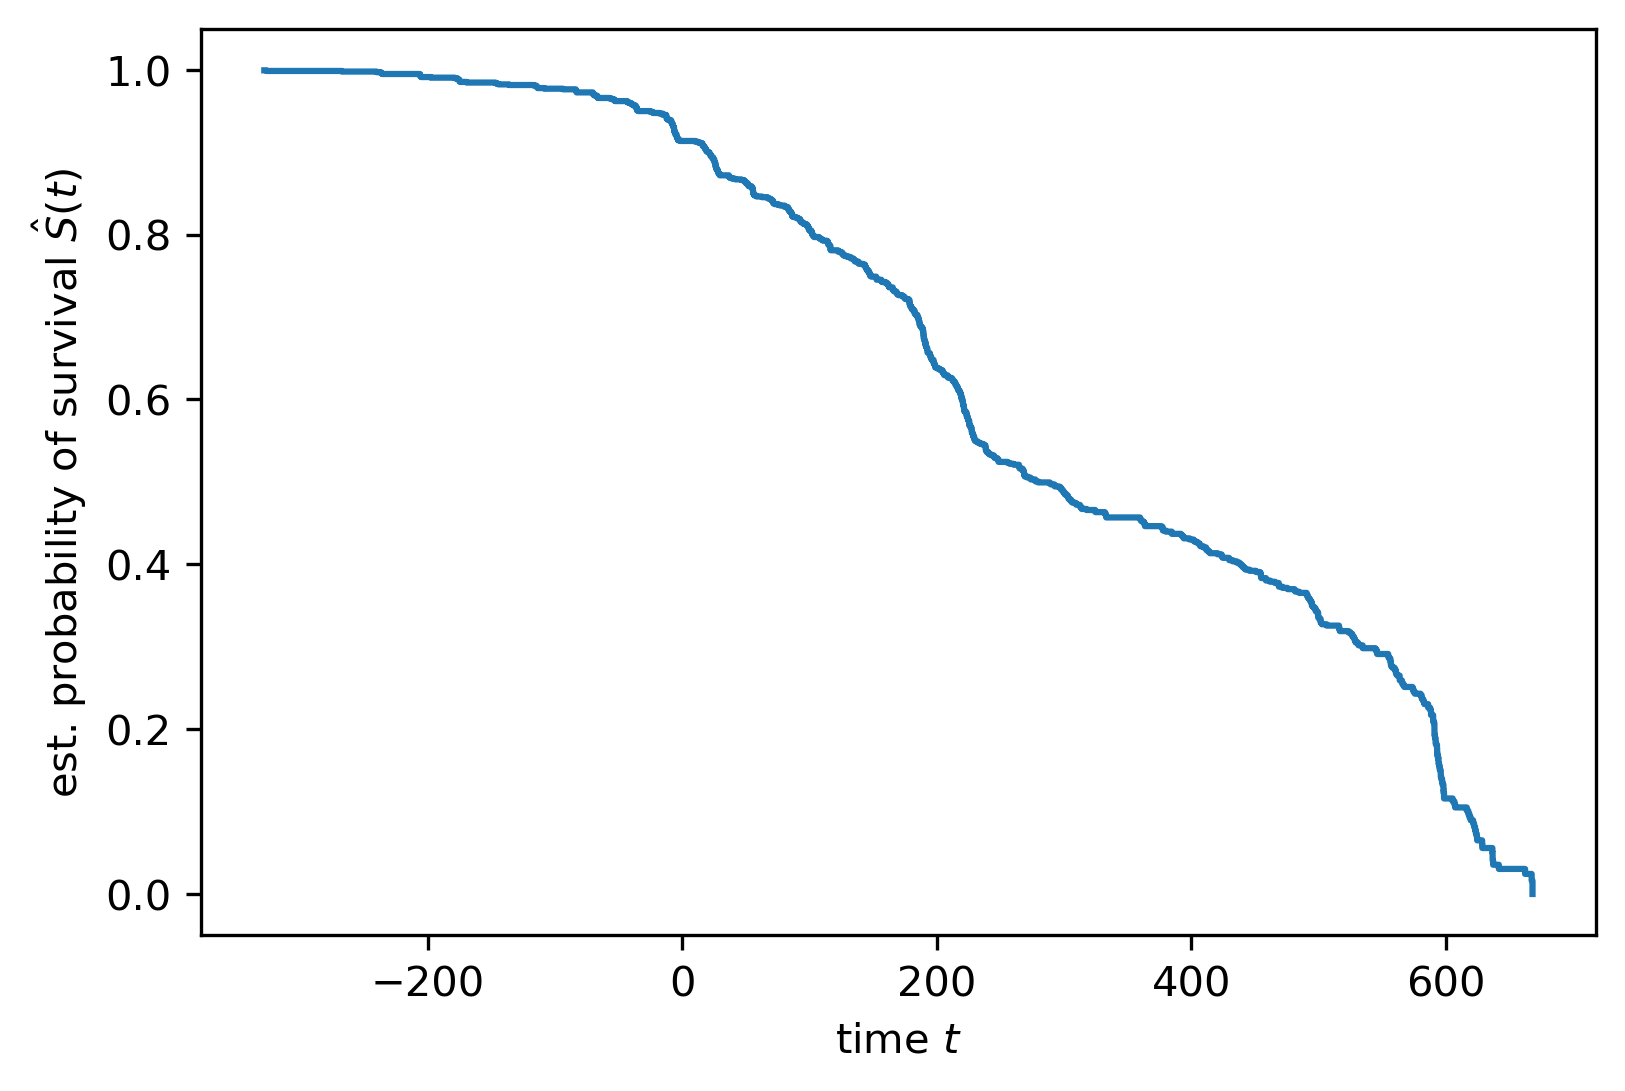

In [114]:
from sksurv.nonparametric import kaplan_meier_estimator
time, survival_prob = kaplan_meier_estimator(smell_df["Status"], smell_df["DurationInDays"])
plt.figure(dpi=300)
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.show()


In [115]:

# study for taste
taste_X = taste_df[['DurationInDays']]
taste_y = taste_df['Taste_current'] - taste_df['Taste_before_illness']


In [116]:
X_train, X_test, y_train, y_test = train_test_split(taste_X, taste_y, test_size=0.2)
lm = LinearRegression()
lm.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Coefficients: 
 [0.00441833]


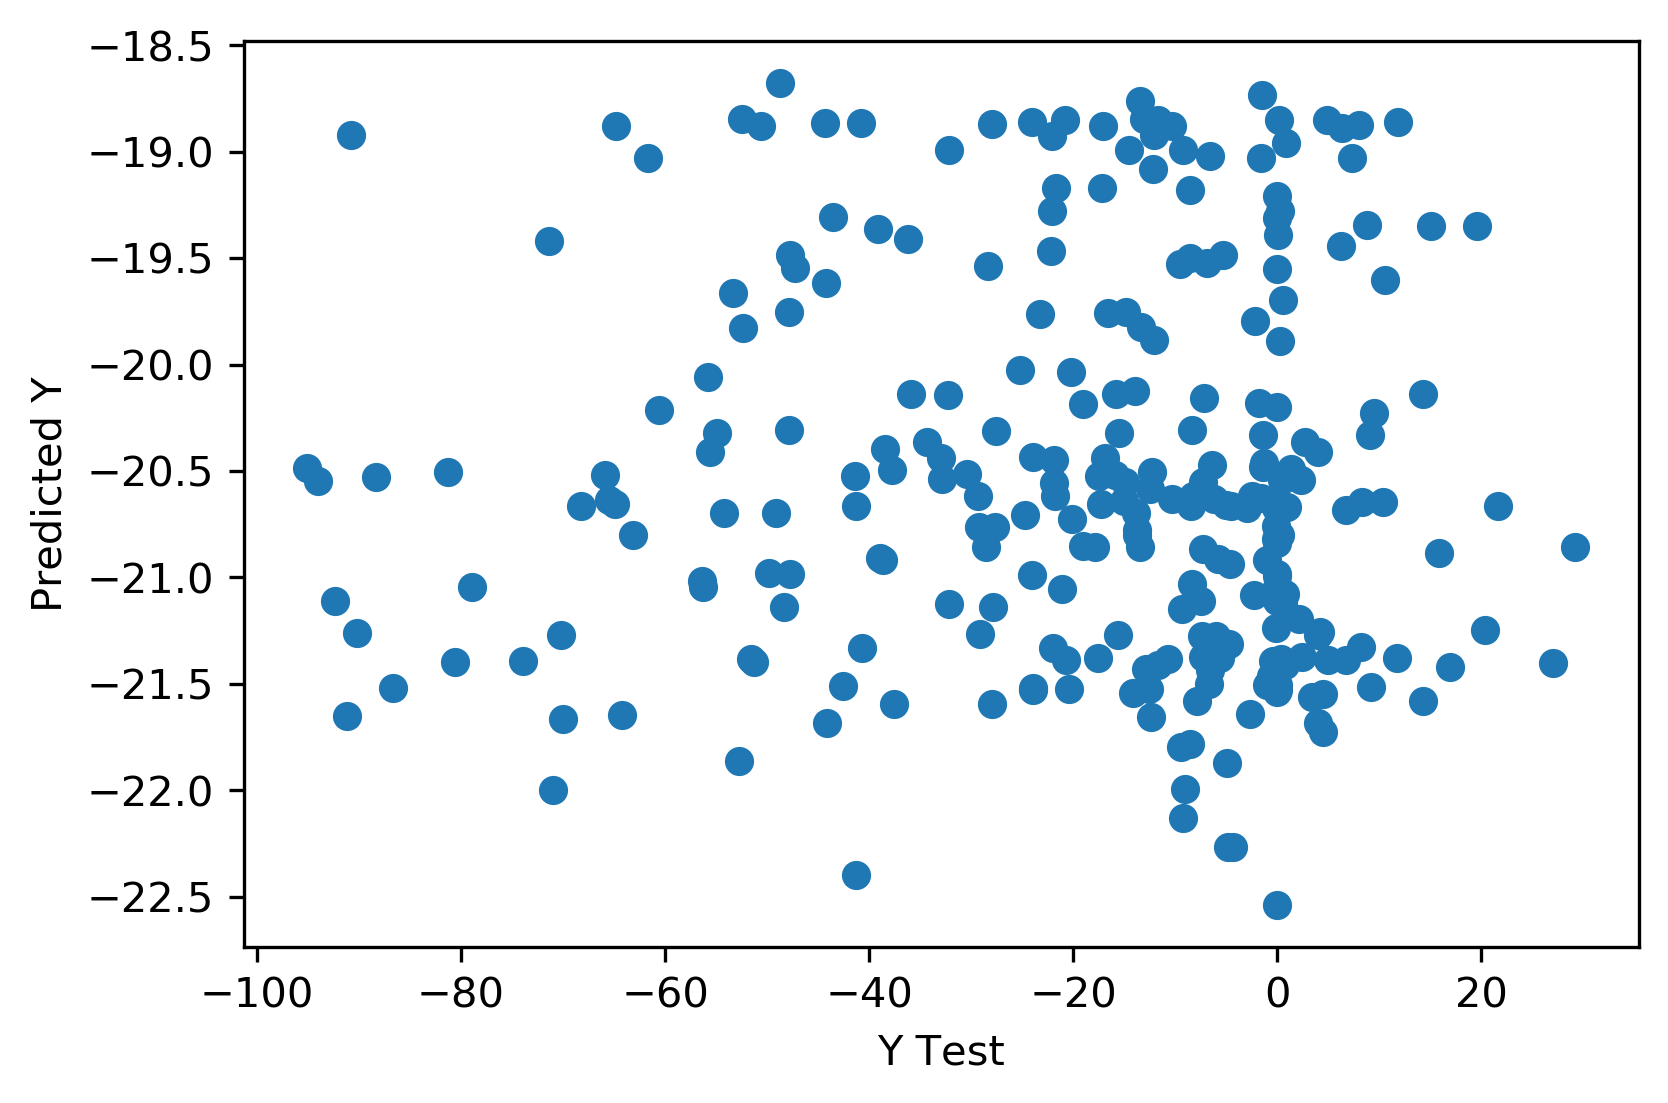

In [117]:
print('Coefficients: \n', lm.coef_)
predictions = lm.predict(X_test)
plt.figure(dpi=300)
plt.scatter(y_test, predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()


In [118]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))


MAE: 20.688480321926836
MSE: 658.1916083863687
RMSE: 25.655245241204938


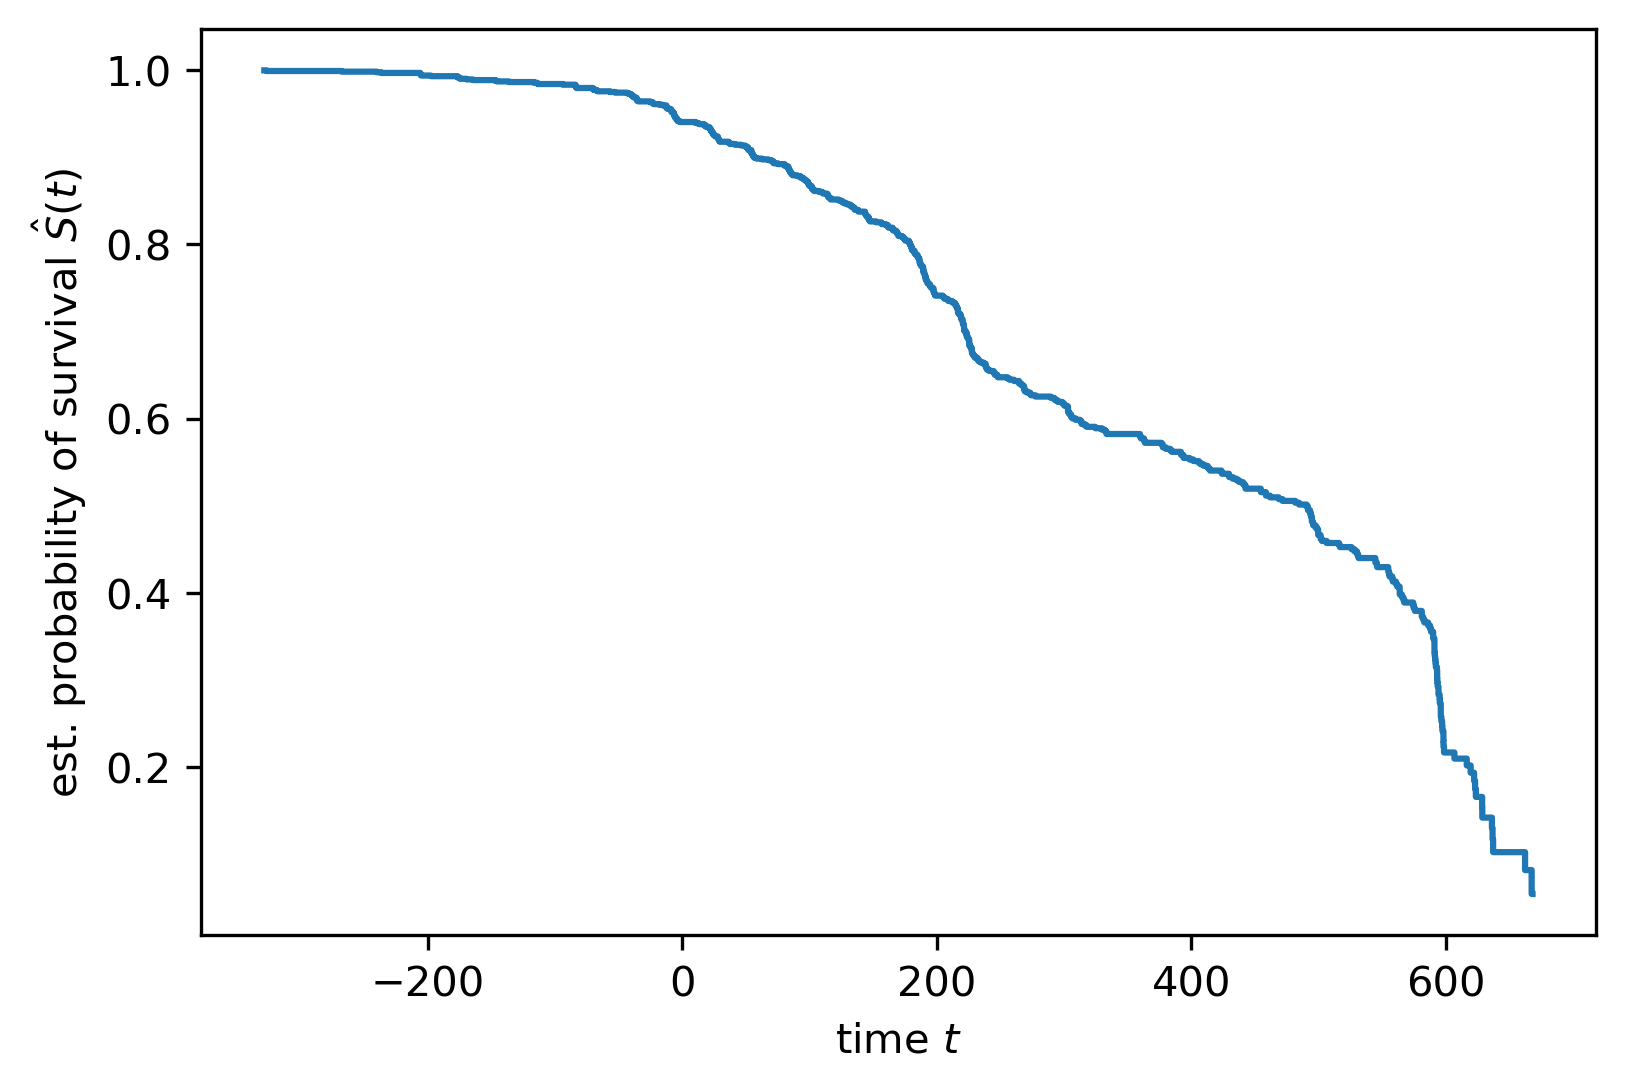

In [119]:
time, survival_prob = kaplan_meier_estimator(taste_df["Status"], taste_df["DurationInDays"])
plt.figure(dpi=300)
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.show()

In [120]:
# data = pd.read_csv(r'C:\Users\tom3r\OneDrive\Desktop\GCCR/gccr003_data.csv',sep=';',encoding= 'unicode_escape')
# data['percentage_recovery'] = data['Smell_current'] / data['Smell_before_illness'] * 100
# data['long_hauler'] = data['percentage_recovery'].apply(lambda x: 1 if x > 80 else 0)


In [ ]:
# smell_df = data[['DurationInDays', 'Smell_before_illness', 'Smell_current', 'Status']]
# taste_df = data[['DurationInDays', 'Taste_before_illness', 'Taste_current', 'Status']]

# Third Aim

# Import data

In [89]:
new_df = pd.read_csv(r'C:/Users/tom3r/OneDrive/Desktop/GCCR/GCCR003_pre-pst-merge_deID_dd_dn_manualcln_v1.csv',encoding= 'unicode_escape')
print(len(new_df))
new_df = new_df.query('Smell_before_illness >= 50')
new_df = new_df.query('Taste_before_illness >= 50')
print(len(new_df))


3392
3213


# Change data types

In [90]:
data["Date_of_onset"] = pd.to_datetime(data["Date_of_onset"], dayfirst=True)
data["Email_Time_Stamp_y"] = pd.to_datetime(data["Email_Time_Stamp_y"], dayfirst=True)

# smell and taste change variables

In [91]:
new_df['percentage_recovery_smell'] = new_df['Smell_current'] / new_df['Smell_before_illness'] * 100
new_df['percentage_recovery_taste'] = new_df['Taste_current'] / new_df['Taste_before_illness'] * 100

# Long hauler

In [92]:
def islonghauler(row):
    percent_smell_recovery = row['percentage_recovery_smell']
    percent_taste_recovery = row['percentage_recovery_taste']
    long_hauler = 0
    
    if (percent_smell_recovery <= 80)  or (percent_taste_recovery<= 80):
        long_hauler =1
    else:
        long_hauler =0
    return long_hauler


In [93]:
new_df['longhauler']=new_df.apply(islonghauler,axis=1)
covid_positive = new_df.copy()
covid_positive = covid_positive.query('COVID_diagnosis_y == 2')


# Only long haulers

In [94]:
# longhauler_df = new_df.query('longhauler == 1') # old

In [95]:
covid_positive_long_haulers = covid_positive.query('longhauler == 1')

In [96]:
symptom_columns = ["Symptoms_fever_y","Symptoms_dry_cough_y","Symptoms_cough_with_mucus_y","Symptoms_difficulty_breathing_/_shortness_of_breath_y","Symptoms_chest_tightness_y","Symptoms_runny_nose_y","Symptoms_sore_throat_y","Symptoms_changes_in_food_flavor_y","Symptoms_changes_in_smell_y","Symptoms_loss_of_appetite_y","Symptoms_headache_y","Symptoms_muscle_aches_y","Symptoms_fatigue_y","Symptoms_diarrhea_y","Symptoms_abdominal_pain_y","Symptoms_nausea_y"]

In [97]:
# new_df['Symptoms_no_symptoms_x'].size # old

covid_positive.longhauler.value_counts()

# len(covid_positive.longhauler)

1    900
0    600
Name: longhauler, dtype: int64

In [51]:
# longhauler_df['Symptoms_no_symptoms_x'].value_counts()

0.0    1815
Name: Symptoms_no_symptoms_x, dtype: int64

In [52]:
# longhauler_df['Symptoms_no_symptoms_y'].value_counts()

0.0    1371
1.0     427
Name: Symptoms_no_symptoms_y, dtype: int64

In [73]:
def symptom_definer(row):
#     no_symptoms_before = 0
#     no_symptoms_after = 0
    current = 0
    first_no_symp = row['Symptoms_no_symptoms_x']
    second_no_symp = row['Symptoms_no_symptoms_y']
    if (first_no_symp ==0) & (second_no_symp==1):
        current = 'recovered' #recovered
    if (first_no_symp ==1) & (second_no_symp==1):
         current = "didnt_have_at_all" #recovered
    if (first_no_symp ==1) & (second_no_symp==0):
         current = "got_symptoms_followup" #recovered
    if (first_no_symp ==0) & (second_no_symp==0):
        current = "still_has_symptoms" #recovered
    if (first_no_symp ==0) & (pd.isnull(second_no_symp)):
        current = "first_sym_second_null" #recovered
    if (first_no_symp ==1) & (pd.isnull(second_no_symp)):
        current = "first_no_sym_second_null" #recovered        
    return current

# new_df['symptoms']=new_df.apply(symptom_definer,axis=1)
covid_positive_long_haulers['symptoms']=covid_positive_long_haulers.apply(symptom_definer,axis=1)

C:\Users\tom3r\anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [76]:
# longhauler_df.symptoms.value_counts()
covid_positive_long_haulers.symptoms.value_counts()

still_has_symptoms       671
recovered                222
first_sym_second_null      7
Name: symptoms, dtype: int64

In [28]:
# new_df['COVID_diagnosis_x'].value_counts().reset_index()

In [17]:
# new_df['COVID_diagnosis_y'].value_counts().reset_index()

,index,COVID_diagnosis_y
0,2.0,1500
1,3.0,763
2,1.0,679
3,6.0,132
4,4.0,106
5,5.0,20


In [18]:
new_df['longhauler'].value_counts()

1    1815
0    1398
Name: longhauler, dtype: int64

In [98]:
symptoms = covid_positive.groupby('longhauler').agg({"Symptoms_fever_y": ['sum','count']}).reset_index()
symptoms

longhauler Symptoms_fever_y      
                          sum count
0          0              1.0   563
1          1              7.0   893

Symptoms_fever_y 
    long_hauler  count  total   percent
0            0    1.0    563  0.177620
1            1    7.0    893  0.783875


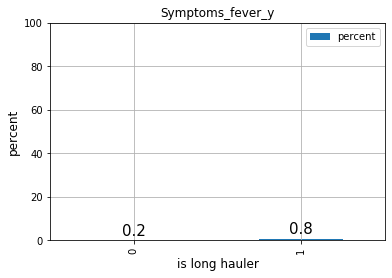

Symptoms_dry_cough_y 
    long_hauler  count  total   percent
0            0   22.0    563  3.907638
1            1   52.0    893  5.823068


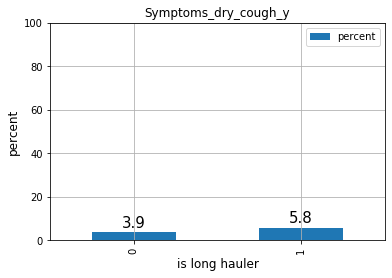

Symptoms_cough_with_mucus_y 
    long_hauler  count  total   percent
0            0   19.0    563  3.374778
1            1   34.0    893  3.807391


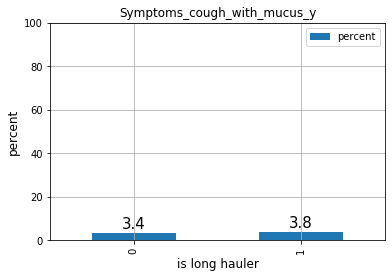

Symptoms_difficulty_breathing_/_shortness_of_breath_y 
    long_hauler  count  total   percent
0            0   32.0    563  5.683837
1            1   88.0    893  9.854423


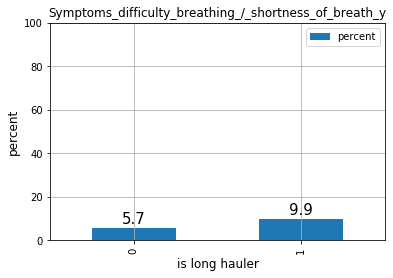

Symptoms_chest_tightness_y 
    long_hauler  count  total   percent
0            0   35.0    563  6.216696
1            1   57.0    893  6.382979


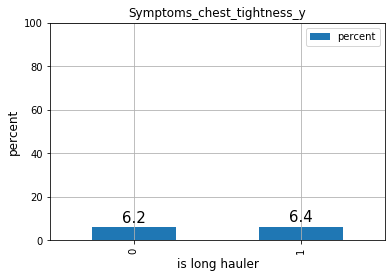

Symptoms_runny_nose_y 
    long_hauler  count  total   percent
0            0   30.0    563  5.328597
1            1   71.0    893  7.950728


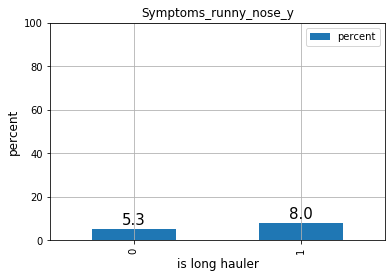

Symptoms_sore_throat_y 
    long_hauler  count  total   percent
0            0   17.0    563  3.019538
1            1   32.0    893  3.583427


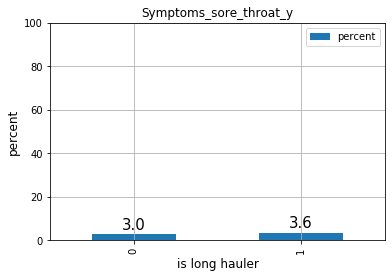

Symptoms_changes_in_food_flavor_y 
    long_hauler  count  total    percent
0            0   58.0    563  10.301954
1            1  411.0    893  46.024636


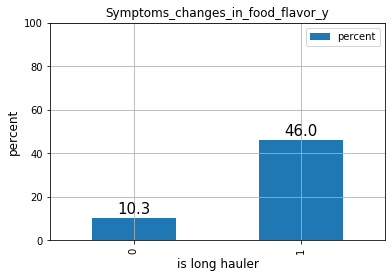

Symptoms_changes_in_smell_y 
    long_hauler  count  total    percent
0            0   82.0    563  14.564831
1            1  543.0    893  60.806271


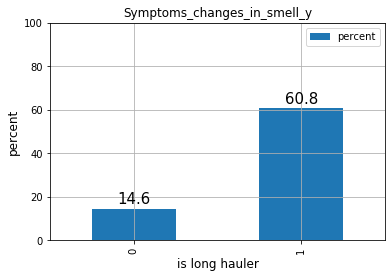

Symptoms_loss_of_appetite_y 
    long_hauler  count  total   percent
0            0    5.0    563  0.888099
1            1   82.0    893  9.182531


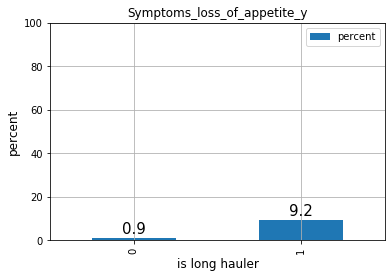

Symptoms_headache_y 
    long_hauler  count  total    percent
0            0   47.0    563   8.348135
1            1  139.0    893  15.565510


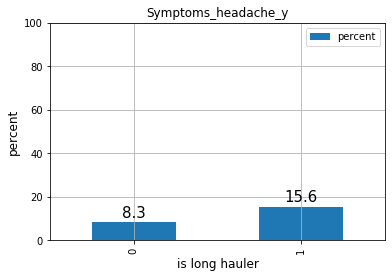

Symptoms_muscle_aches_y 
    long_hauler  count  total    percent
0            0   40.0    563   7.104796
1            1   96.0    893  10.750280


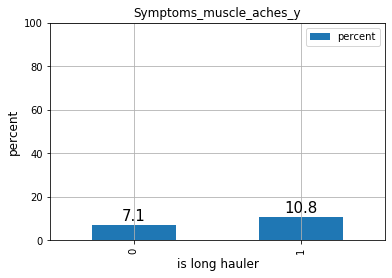

Symptoms_fatigue_y 
    long_hauler  count  total    percent
0            0   99.0    563  17.584369
1            1  255.0    893  28.555431


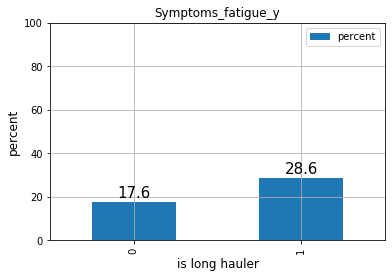

Symptoms_diarrhea_y 
    long_hauler  count  total   percent
0            0    9.0    563  1.598579
1            1   32.0    893  3.583427


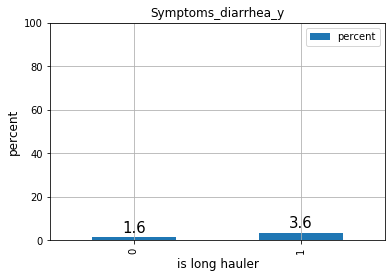

Symptoms_abdominal_pain_y 
    long_hauler  count  total   percent
0            0   19.0    563  3.374778
1            1   34.0    893  3.807391


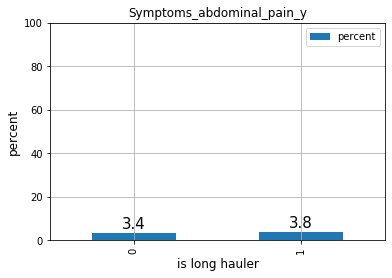

Symptoms_nausea_y 
    long_hauler  count  total   percent
0            0   13.0    563  2.309059
1            1   35.0    893  3.919373


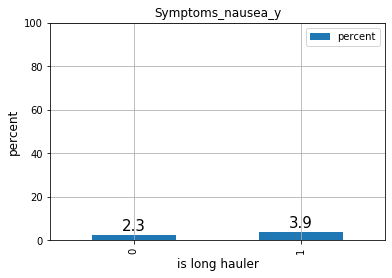

In [27]:
covid_positive = new_df.copy()
covid_positive = covid_positive.query('COVID_diagnosis_y == 2')
for i in symptoms_columns:
    symptoms = covid_positive.groupby('longhauler').agg({i: ['sum','count']}).reset_index()
    symptoms.columns = ['long_hauler','count','total']
    symptoms['percent'] = (symptoms['count'] / symptoms['total'])* 100
    
    print(i,"\n",symptoms)
#     symptoms['percent'].hist()
    splot = symptoms.plot('long_hauler','percent',kind="bar",ylim=(0,100),grid=True)
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.1f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       size=15,
                       xytext = (0, 9), 
                       textcoords = 'offset points')
    plt.title(i)
    plt.ylabel('percent',size='12')
    plt.xlabel('is long hauler',size='12')
    plt.show()

# symptoms['percent'] = symptoms['sum'] / symptoms['count']

In [195]:
# data['long_hauler'] = data['percentage_recovery'].apply(lambda x: 1 if x > 80 else 0)


# aim_1_test

In [9]:
# # create new dataframe variables
# smell_df = data[['DurationInDays', 'Smell_before_illness', 'Smell_current', 'Status']]
# taste_df = data[['DurationInDays', 'Taste_before_illness', 'Taste_current', 'Status']]

# # drop nan records
# smell_df = smell_df.dropna()
# taste_df = taste_df.dropna()

# smell_df["Smell_before_illness"] = pd.to_numeric(smell_df["Smell_before_illness"])


# # Individuals who reported severe chemosensory dysfunction pre-COVID (i.e., before illness rating <50 for “before illness rating” on the original survey) will be excluded.
# smell_df = smell_df[smell_df['Smell_before_illness'] >= 50]
# #taste_df = taste_df[taste_df['Taste_before_illness'] >= 50]

# # calculate recovery percentages
# smell_df['percentage_recovery'] = smell_df['Smell_current'] / smell_df['Smell_before_illness'] * 100
# #taste_df['percentage_recovery'] = taste_df['Taste_current'] / taste_df['Taste_before_illness'] * 100

In [6]:
# smell_df
# taste_df

NameError: name 'smell_df' is not defined

In [7]:
# new_df['longhauler'] = new_df["longhauler"].astype('bool')


NameError: name 'new_df' is not defined

In [199]:
# new_df['Date_of_onset'] = pd.to_datetime(new_df['Date_of_onset'])
# new_df['Email_Time_Stamp_y'] = pd.to_datetime(new_df['Email_Time_Stamp_y'])
# new_df['days_from_onset'] = ((new_df['Email_Time_Stamp_y'] - new_df['Date_of_onset']).dt.total_seconds()/(60*60*24))

In [200]:

# smell_X = new_df[['days_from_onset']]
# smell_y = new_df['Smell_current'] - new_df['Smell_before_illness']

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(smell_X, smell_y, test_size=0.2)
# lm = LinearRegression()
# lm.fit(X_train, y_train)

# print('Coefficients: \n', lm.coef_)
# predictions = lm.predict(X_test)
# plt.figure(dpi=300)
# plt.scatter(y_test, predictions)
# plt.xlabel('Y Test')
# plt.ylabel('Predicted Y')
# plt.show()

# print('MAE:', metrics.mean_absolute_error(y_test, predictions))
# print('MSE:', metrics.mean_squared_error(y_test, predictions))
# print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

# time, survival_prob = kaplan_meier_estimator(smell_df["Status"], smell_df["DurationInDays"])
# plt.figure(dpi=300)
# plt.step(time, survival_prob, where="post")
# plt.ylabel("est. probability of survival $\hat{S}(t)$")
# plt.xlabel("time $t$")
# plt.show()